In [326]:
import os
import random
import pathlib
import time
import struct
import json

from PIL import Image
from IPython.display import Image as ip_Image
from IPython.display import display as ip_display

import numpy as np
import pandas as pd
import phik

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot

from tqdm.notebook import tqdm

from datasets import load_dataset, load_metric

In [327]:
PROJECT_FOLDER = os.path.abspath(os.path.join(pathlib.Path().resolve(), os.pardir))

HOUSES_NOTEBOOKS_FOLDER = pathlib.Path().resolve()

HOUSES_FILES_FOLDER = os.path.join(PROJECT_FOLDER, 'houses_files')

if not os.path.isdir(HOUSES_FILES_FOLDER):
   os.makedirs(HOUSES_FILES_FOLDER)

# Датасет

In [328]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [329]:
df =  california_housing.frame
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


## Более подробный взгляд на признаки данных

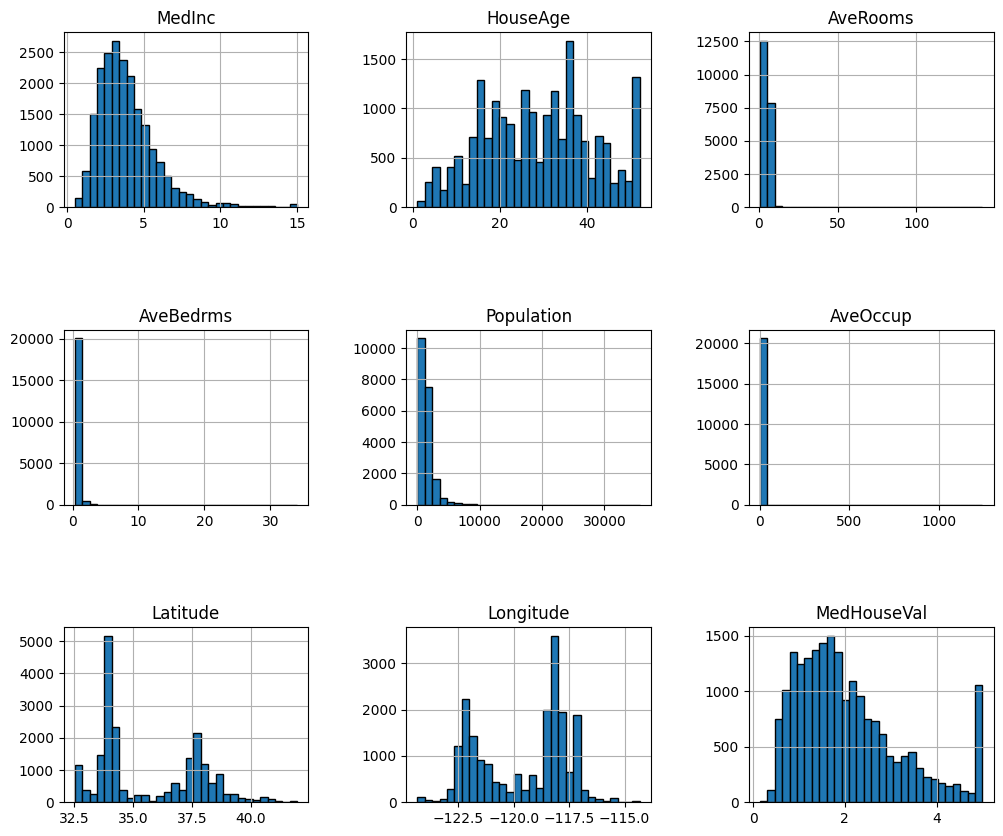

In [331]:
df.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [332]:
df.describe()
# Видим значительные расхождения между 75% персентилем и макс значением

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Text(0, 0.5, 'Latitude (широта)')

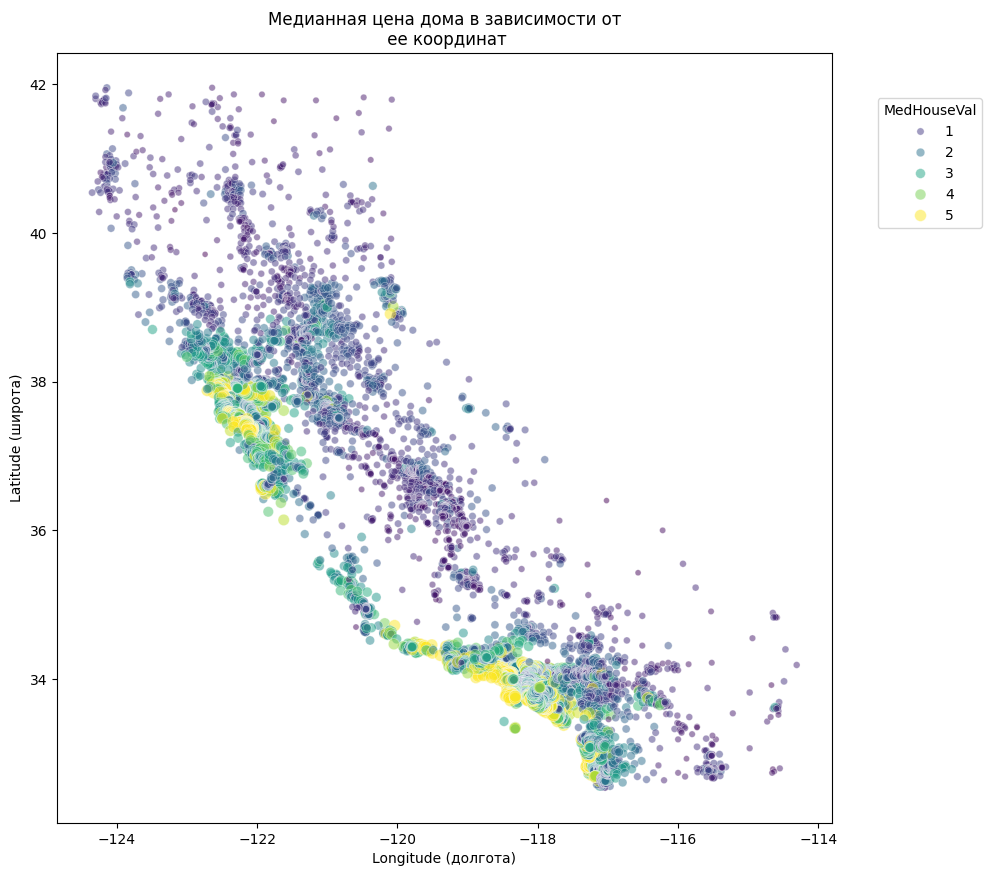

In [333]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df,
    x="Longitude",
    y="Latitude",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
plt.title("Медианная цена дома в зависимости от\n ее координат")
plt.xlabel('Longitude (долгота)')
plt.ylabel('Latitude (широта)')

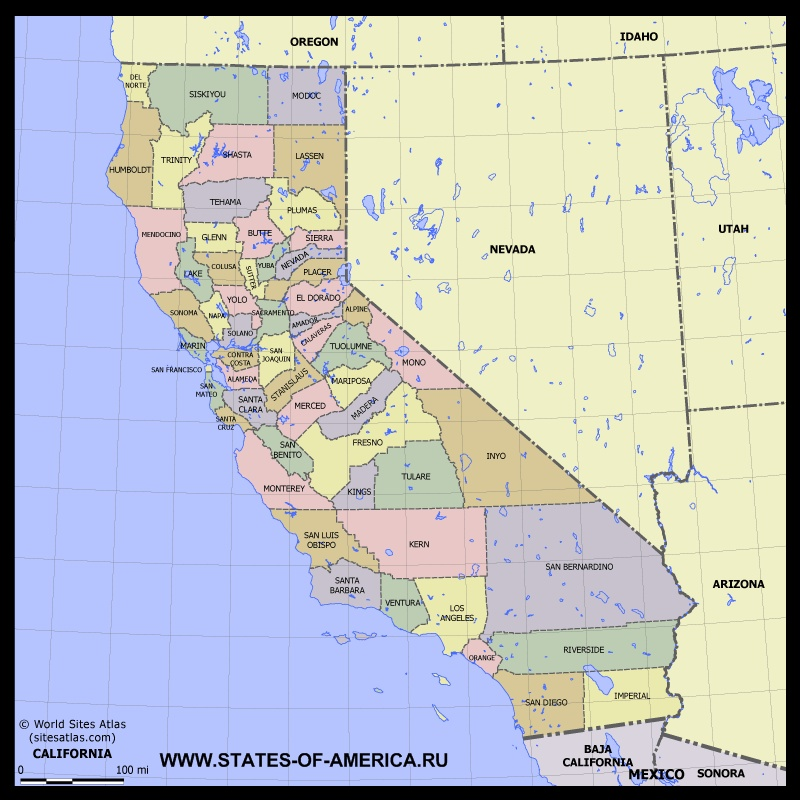

In [334]:
ip_display(ip_Image(filename=os.path.join(HOUSES_FILES_FOLDER, 'california_map.jpeg'), width=600))
#Image.open(os.path.join(HOUSES_FILES_FOLDER, 'california_map.jpeg')).show()

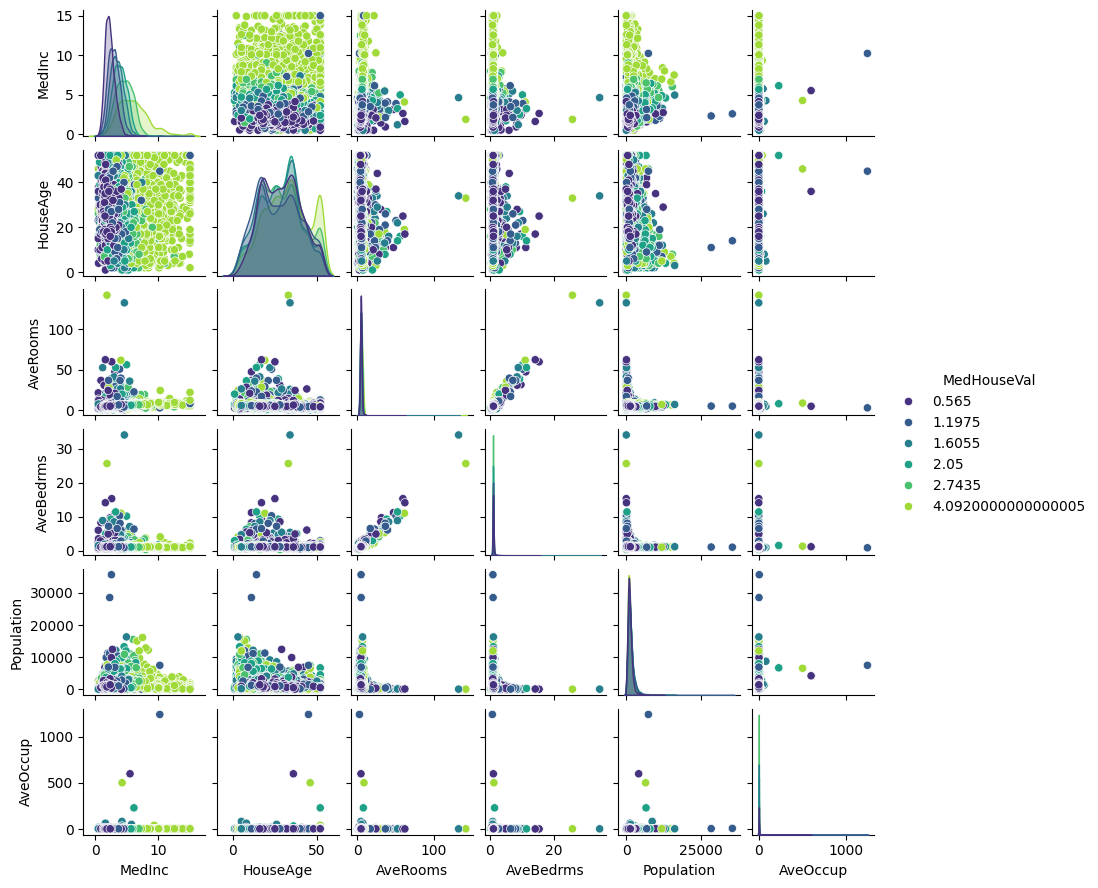

In [335]:
subset = df.drop(columns=["Longitude", "Latitude"])
subset["MedHouseVal"] = pd.qcut(subset["MedHouseVal"], 6, retbins=False)    # разбили значения MedHouseVal на 6 интервалов
subset["MedHouseVal"] = subset["MedHouseVal"].apply(lambda x: x.mid)
sns.pairplot(data=subset, hue="MedHouseVal", palette="viridis", height=1.5)
plt.show()

Видны выбросы, от которых следует избавиться

# Работа с данными

## Взгляд на хвосты

Для начала посмотрим на количество объектов, цена которых равна максимальной.

In [336]:
max_target=df['MedHouseVal'].max()
print(f'Максимальное значение медианы цена: {max_target}')
print(f'Количество объектов, MedHouseVal у которых равен максимальному: {sum(df['MedHouseVal']==max_target)}')
print(f'Процент объектов, MedHouseVal у которых равен максимальному: {sum(df['MedHouseVal']==max_target)/df.shape[0]:.3f}')

Максимальное значение медианы цена: 5.00001
Количество объектов, MedHouseVal у которых равен максимальному: 965
Процент объектов, MedHouseVal у которых равен максимальному: 0.047


Видим, что около 5% значений равны максимальному.

Проверим, все ли в порядке с минимальным:

In [337]:
min_target=df['MedHouseVal'].min()
print(f'Минимальное значение медианы: {min_target}')
print(f'Количество объектов, MedHouseVal у которых равен минимальному: {sum(df['MedHouseVal']==min_target)}')
print(f'Процент объектов, MedHouseVal у которых равен минимальному: {sum(df['MedHouseVal']==min_target)/df.shape[0]:.5f}')

Минимальное значение медианы: 0.14999
Количество объектов, MedHouseVal у которых равен минимальному: 4
Процент объектов, MedHouseVal у которых равен минимальному: 0.00019


С минимальными значениями все хорошо

## Проверка на нормальность

Проверим, является ли наша выборка нормально распределенной:

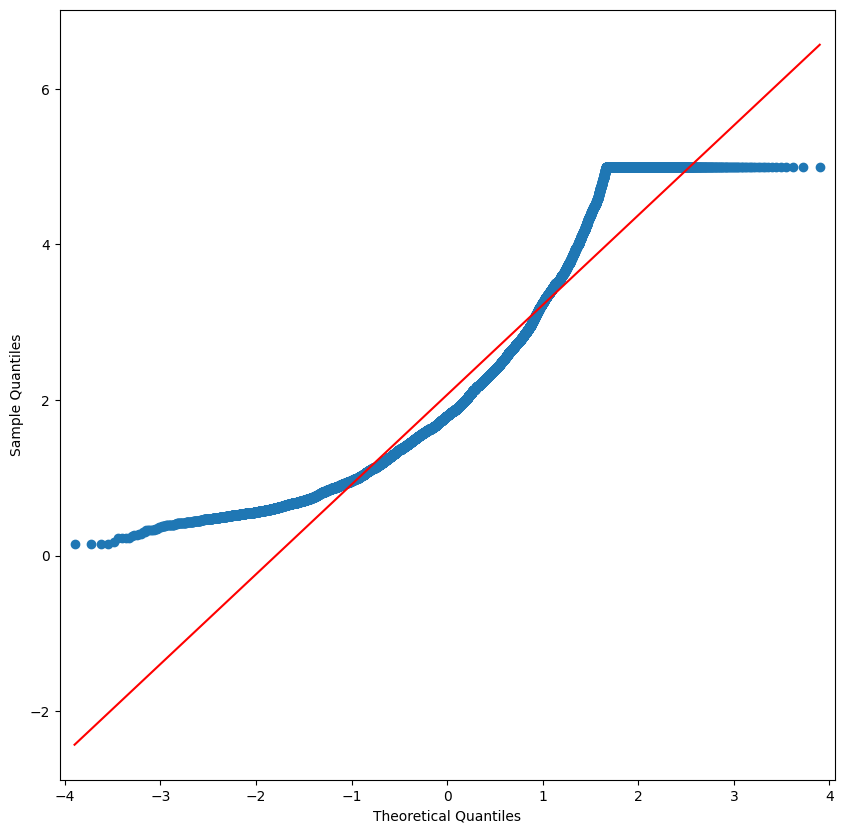

In [338]:
fig, ax = plt.subplots(figsize=(10, 10))
qqplot(df['MedHouseVal'], line='s', ax=ax)
plt.show()

In [339]:
print(f'Нулевая гипотеза: распределение принадлежит семейству нормальных')
print(f'Оценим вероятность, с которой мы получили бы такое распределение при верной нулевой гипотезе')

stat, p = normaltest(df['MedHouseVal'])
print(f'Статистика равна = {stat:.3f}, вероятность p = {p:.3f}')

alpha = 0.05

if p < alpha:
    print("Нулевая гипотеза отвергнута")
else:
    print("Нулевая гипотеза принята")

Нулевая гипотеза: распределение принадлежит семейству нормальных
Оценим вероятность, с которой мы получили бы такое распределение при верной нулевой гипотезе
Статистика равна = 2430.931, вероятность p = 0.000
Нулевая гипотеза отвергнута


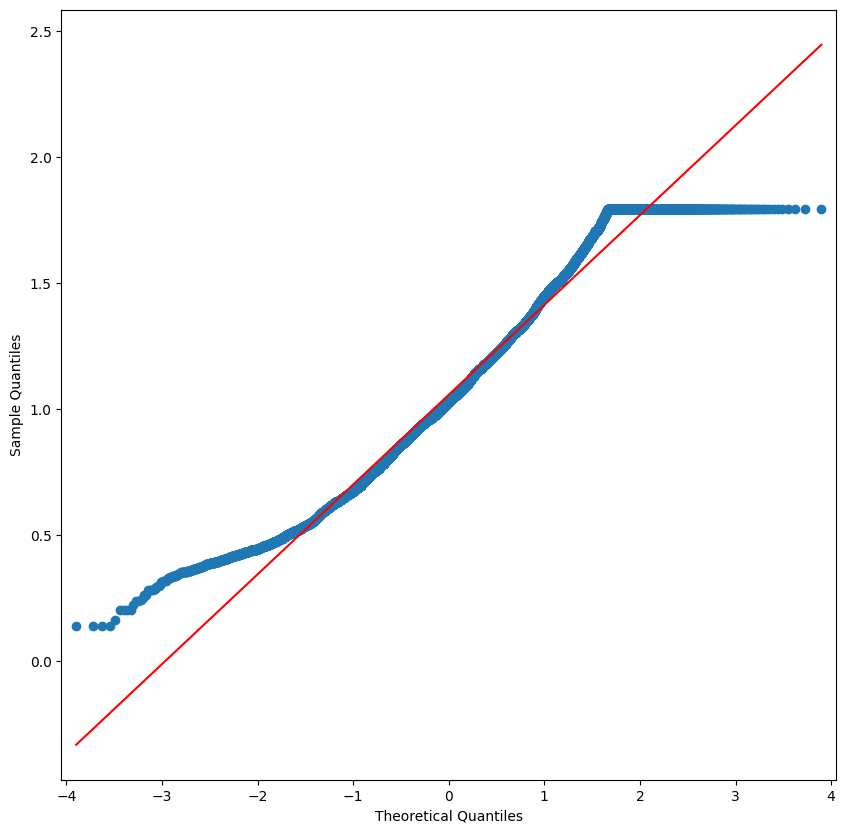

In [340]:
target_log=np.log1p(df['MedHouseVal'])
fig, ax = plt.subplots(figsize=(10, 10))
qqplot(target_log, line='s', ax=ax)
plt.show()

In [341]:
print(f'Нулевая гипотеза: логарифм распределения принадлежит семейству нормальных')
print(f'Оценим вероятность, с которой мы получили бы такое распределение при верной нулевой гипотезе')

stat, p = normaltest(target_log)
print(f'Статистика равна = {stat:.3f}, вероятность p = {p:.3f}')

alpha = 0.05

if p < alpha:
    print("Нулевая гипотеза отвергнута")
else:
    print("Нулевая гипотеза принята")

Нулевая гипотеза: логарифм распределения принадлежит семейству нормальных
Оценим вероятность, с которой мы получили бы такое распределение при верной нулевой гипотезе
Статистика равна = 915.344, вероятность p = 0.000
Нулевая гипотеза отвергнута


Выкинем из нашей выборки 5% максимальных значений и проведем тесты еще раз

In [342]:
upper_threshold = df['MedHouseVal'].quantile(0.95)
df = df[df['MedHouseVal'] <= upper_threshold]

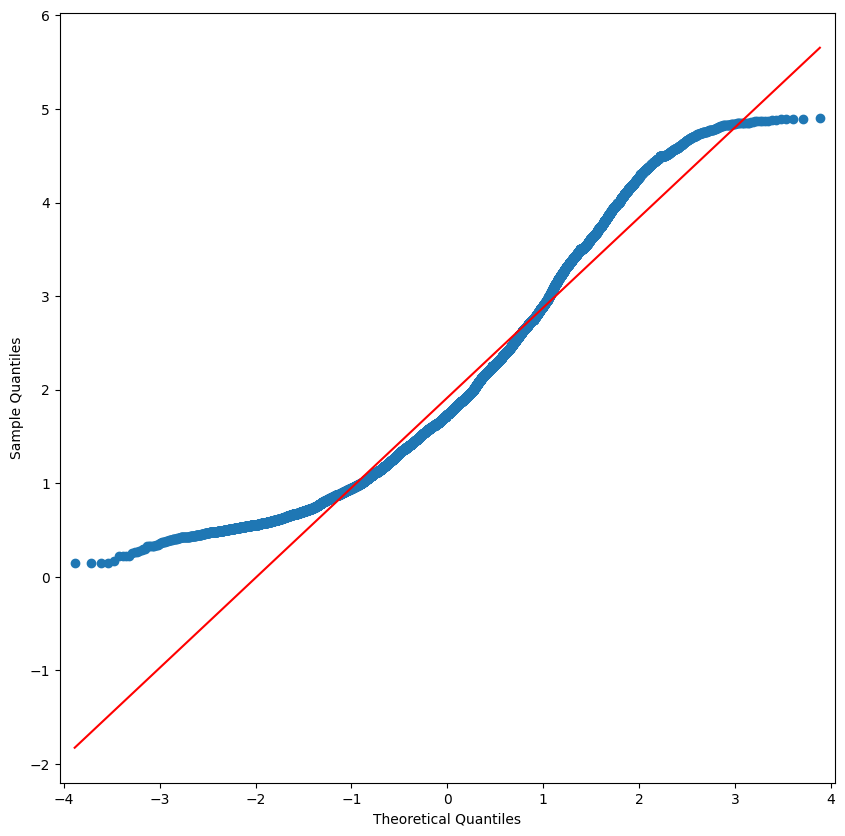

Нулевая гипотеза: распределение принадлежит семейству нормальных
Оценим вероятность, с которой мы получили бы такое распределение при верной нулевой гипотезе
Статистика равна = 1558.357, вероятность p = 0.000
Нулевая гипотеза отвергнута


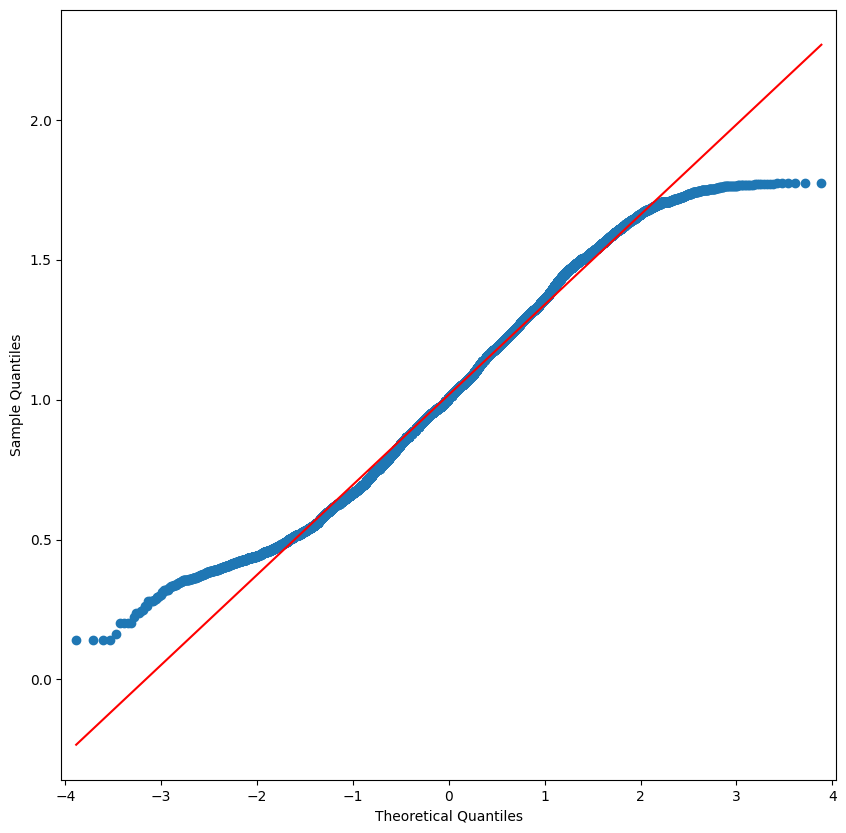

Нулевая гипотеза: логарифм распределения принадлежит семейству нормальных
Оценим вероятность, с которой мы получили бы такое распределение при верной нулевой гипотезе
Статистика равна = 935.978, вероятность p = 0.000
Нулевая гипотеза отвергнута


In [343]:
fig, ax = plt.subplots(figsize=(10, 10))
qqplot(df['MedHouseVal'], line='s', ax=ax)
plt.show()

print(f'Нулевая гипотеза: распределение принадлежит семейству нормальных')
print(f'Оценим вероятность, с которой мы получили бы такое распределение при верной нулевой гипотезе')

stat, p = normaltest(df['MedHouseVal'])
print(f'Статистика равна = {stat:.3f}, вероятность p = {p:.3f}')

alpha = 0.05

if p < alpha:
    print("Нулевая гипотеза отвергнута")
else:
    print("Нулевая гипотеза принята")



target_log=np.log1p(df['MedHouseVal'])
fig, ax = plt.subplots(figsize=(10, 10))
qqplot(target_log, line='s', ax=ax)
plt.show()

print(f'Нулевая гипотеза: логарифм распределения принадлежит семейству нормальных')
print(f'Оценим вероятность, с которой мы получили бы такое распределение при верной нулевой гипотезе')

stat, p = normaltest(target_log)
print(f'Статистика равна = {stat:.3f}, вероятность p = {p:.3f}')

alpha = 0.05

if p < alpha:
    print("Нулевая гипотеза отвергнута")
else:
    print("Нулевая гипотеза принята")

Как видно, распределение все равно не нормальное

## Работа с масштабом признаков

Применим логарифмическую шкалу к признакам с "плохим" масштабом

In [344]:
skewed_features=['AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedInc']
log_skewed_features=[]
for f in skewed_features:
    df[f + '_log']=np.log1p(df[f])
    df[f + '_log']=np.log1p(df[f])
    log_skewed_features.append(f + '_log')
df

C:\Users\User\AppData\Local\Temp\ipykernel_8120\2555177288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f + '_log']=np.log1p(df[f])
C:\Users\User\AppData\Local\Temp\ipykernel_8120\2555177288.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f + '_log']=np.log1p(df[f])
C:\Users\User\AppData\Local\Temp\ipykernel_8120\2555177288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,AveRooms_log,AveBedrms_log,Population_log,AveOccup_log,MedInc_log
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,2.077455,0.704982,5.777652,1.268511,2.232720
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,1.979364,0.678988,7.784057,1.134572,2.230165
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,2.228738,0.729212,6.208590,1.335596,2.111110
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1.919471,0.729025,6.326149,1.266369,1.893579
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1.985385,0.732888,6.338594,1.157342,1.578195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,1.799307,0.757686,6.740519,1.269931,0.940124
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,1.962070,0.839751,5.877736,1.416534,1.268861
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,1.825443,0.751460,6.915723,1.201661,0.993252
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,1.845223,0.775611,6.609349,1.138861,1.053336


Выкинем выбросы по AveOccup

In [345]:
upper_threshold = df['AveOccup'].quantile(0.9995)
df[df['AveOccup'] >= upper_threshold]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,AveRooms_log,AveBedrms_log,Population_log,AveOccup_log,MedInc_log
3364,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51,0.675,1.815290,0.762140,8.342602,6.398119,1.874552
5986,1.8750,52.0,4.500000,1.206349,2688.0,21.333333,34.10,-117.71,2.125,1.704748,0.791339,7.896925,3.106080,1.056053
9172,4.2391,5.0,5.123810,0.933333,8733.0,83.171429,34.47,-118.59,1.546,1.812184,0.659246,9.074979,4.432856,1.656150
12104,1.6250,8.0,7.600000,0.950000,1275.0,63.750000,33.97,-117.33,1.625,2.151762,0.667829,7.151485,4.170534,0.965081
13034,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15,2.250,2.227416,0.923164,8.806274,5.443164,1.965138
13366,4.2578,36.0,5.258824,1.117647,2886.0,33.952941,33.94,-117.63,1.833,1.833992,0.750306,7.967973,3.554003,1.659713
16420,5.7485,26.0,5.366667,0.900000,1542.0,51.400000,37.89,-121.29,1.625,1.851076,0.641854,7.341484,3.958907,1.909320
16669,4.2639,46.0,9.076923,1.307692,6532.0,502.461538,35.32,-120.70,3.500,2.310248,0.836248,8.784622,6.221507,1.660872
19006,10.2264,45.0,3.166667,0.833333,7460.0,1243.333333,38.32,-121.98,1.375,1.427116,0.606136,8.917445,7.126355,2.418268
20352,4.0208,8.0,2.500000,0.625000,309.0,19.312500,34.22,-119.09,0.525,1.252763,0.485508,5.736572,3.011236,1.613589


In [346]:
df = df[df['AveOccup'] <= 30]

Выкинем выбросы по Population

In [347]:
upper_threshold = df['Population'].quantile(0.9995)
df[df['Population'] >= upper_threshold]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,AveRooms_log,AveBedrms_log,Population_log,AveOccup_log,MedInc_log
922,8.4045,7.0,7.635234,1.044042,12203.0,3.297217,37.53,-121.92,4.511,2.155851,0.714929,9.409519,1.457968,2.241188
6057,6.0191,8.0,6.347327,1.047525,15507.0,3.070693,34.03,-117.78,2.539,1.994337,0.716632,9.649111,1.403813,1.948635
6066,6.6288,7.0,6.802554,1.026277,15037.0,3.692780,34.04,-117.87,3.397,2.054451,0.706200,9.618336,1.546025,2.031931
9019,8.0137,9.0,7.734673,1.041211,12873.0,3.274739,34.16,-118.78,3.992,2.167301,0.713543,9.462965,1.452723,2.198746
9880,2.3087,11.0,5.364518,1.059684,28566.0,4.696810,36.64,-121.79,1.188,1.850739,0.722553,10.260007,1.739906,1.196555
10309,7.4947,4.0,7.311043,1.054346,16122.0,3.106957,33.89,-117.74,3.663,2.117585,0.719957,9.688002,1.412682,2.139442
12215,4.5841,4.0,7.006453,1.142429,13251.0,3.053929,33.52,-117.12,2.123,2.080248,0.761940,9.491904,1.399687,1.719923
13139,4.9516,3.0,7.338559,1.159015,16305.0,3.043113,38.43,-121.44,1.537,2.120890,0.769652,9.699288,1.397015,1.783660
15360,2.5729,14.0,5.270497,1.010484,35682.0,7.482072,33.35,-117.42,1.344,1.835856,0.698376,10.482430,2.137955,1.273378
17413,2.7377,29.0,6.276716,1.101911,12427.0,4.397381,34.70,-120.59,0.283,1.984680,0.742847,9.427707,1.685914,1.318470


In [348]:
df = df[df['Population'] <= 25000]

Выкинем выбросы по AveRooms

In [349]:
upper_threshold = df['AveRooms'].quantile(0.9995)
df[df['AveRooms'] >= upper_threshold]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,AveRooms_log,AveBedrms_log,Population_log,AveOccup_log,MedInc_log
1240,3.1250,11.0,47.515152,11.181818,82.0,2.484848,38.42,-120.19,0.775,3.881876,2.499945,4.418841,1.248425,1.417066
1912,4.9750,16.0,56.269231,10.153846,54.0,2.076923,39.01,-120.16,2.063,4.047763,2.411784,4.007333,1.123930,1.787584
1913,4.0714,19.0,61.812500,11.000000,112.0,2.333333,39.01,-120.06,4.375,4.140154,2.484907,4.727388,1.203973,1.623617
1979,4.6250,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08,1.625,4.894351,3.557251,3.610918,1.223775,1.727221
2395,3.8750,23.0,50.837838,10.270270,64.0,1.729730,37.12,-119.34,1.250,3.948120,2.422168,4.174387,1.004203,1.584120
9676,3.2431,14.0,52.848214,11.410714,265.0,2.366071,37.64,-119.02,2.214,3.986169,2.518560,5.583496,1.213746,1.445294
11707,1.1912,22.0,52.690476,8.857143,98.0,2.333333,39.15,-120.06,1.700,3.983236,2.288196,4.595120,1.203973,0.784449
11832,3.0000,16.0,41.333333,8.476190,44.0,2.095238,39.30,-120.33,1.750,3.745575,2.248782,3.806662,1.129865,1.386294
11862,2.6250,25.0,59.875000,15.312500,28.0,1.750000,40.27,-121.25,0.675,4.108823,2.791932,3.367296,1.011601,1.287854
12447,1.6154,17.0,62.422222,14.111111,83.0,1.844444,33.97,-114.49,0.875,4.149814,2.715430,4.430817,1.045368,0.961417


In [350]:
df = df[df['AveRooms'] <= 120]

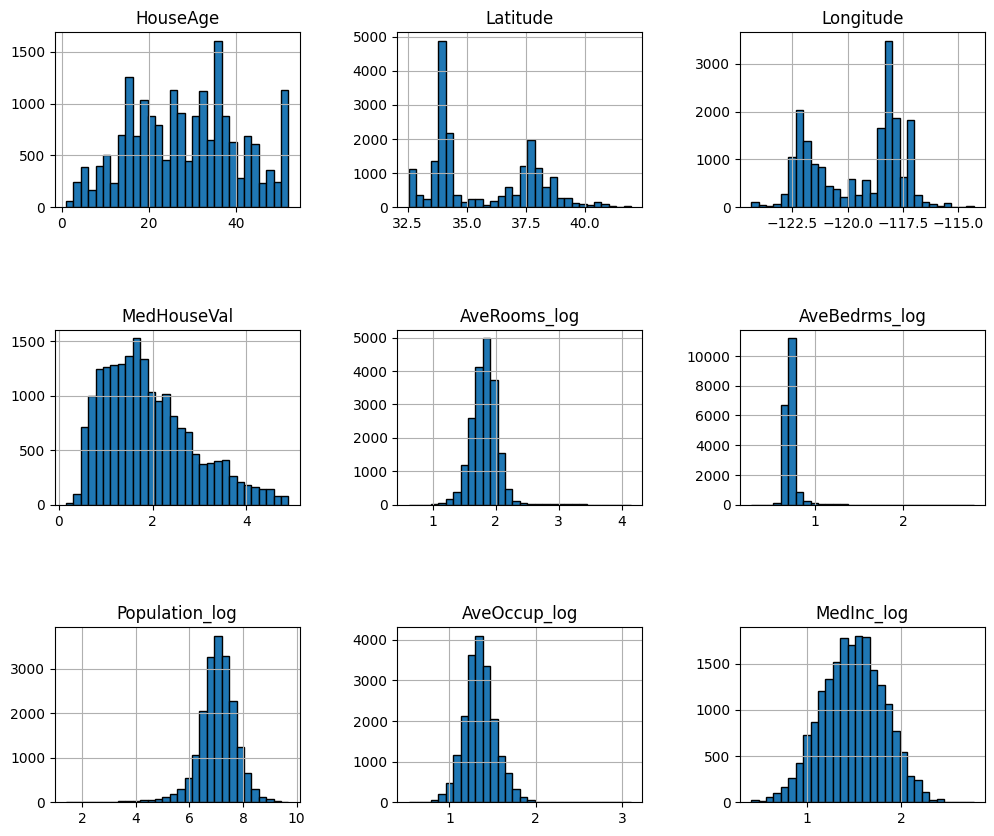

In [351]:
df.drop(columns=skewed_features).hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.show()

In [352]:
df.drop(columns=skewed_features, inplace=True)

Убедимся, что выбросов больше нет:

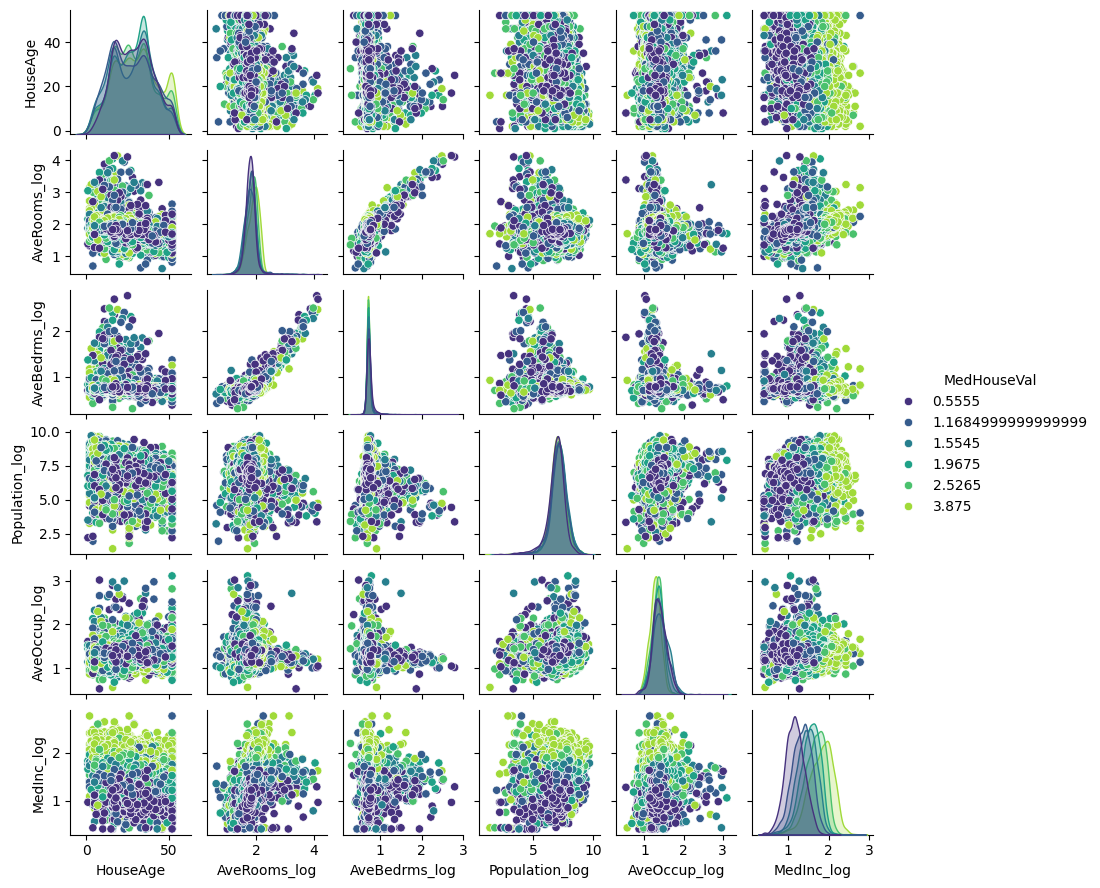

In [353]:
subset = df.drop(columns=["Longitude", "Latitude"])
subset["MedHouseVal"] = pd.qcut(subset["MedHouseVal"], 6, retbins=False)    # разбили значения MedHouseVal на 6 интервалов
subset["MedHouseVal"] = subset["MedHouseVal"].apply(lambda x: x.mid)
_ = sns.pairplot(data=subset, hue="MedHouseVal", palette="viridis", height=1.5)

## Взгляд на корреляцию

interval columns not set, guessing: ['HouseAge', 'Latitude', 'Longitude', 'MedHouseVal', 'AveRooms_log', 'AveBedrms_log', 'Population_log', 'AveOccup_log', 'MedInc_log']


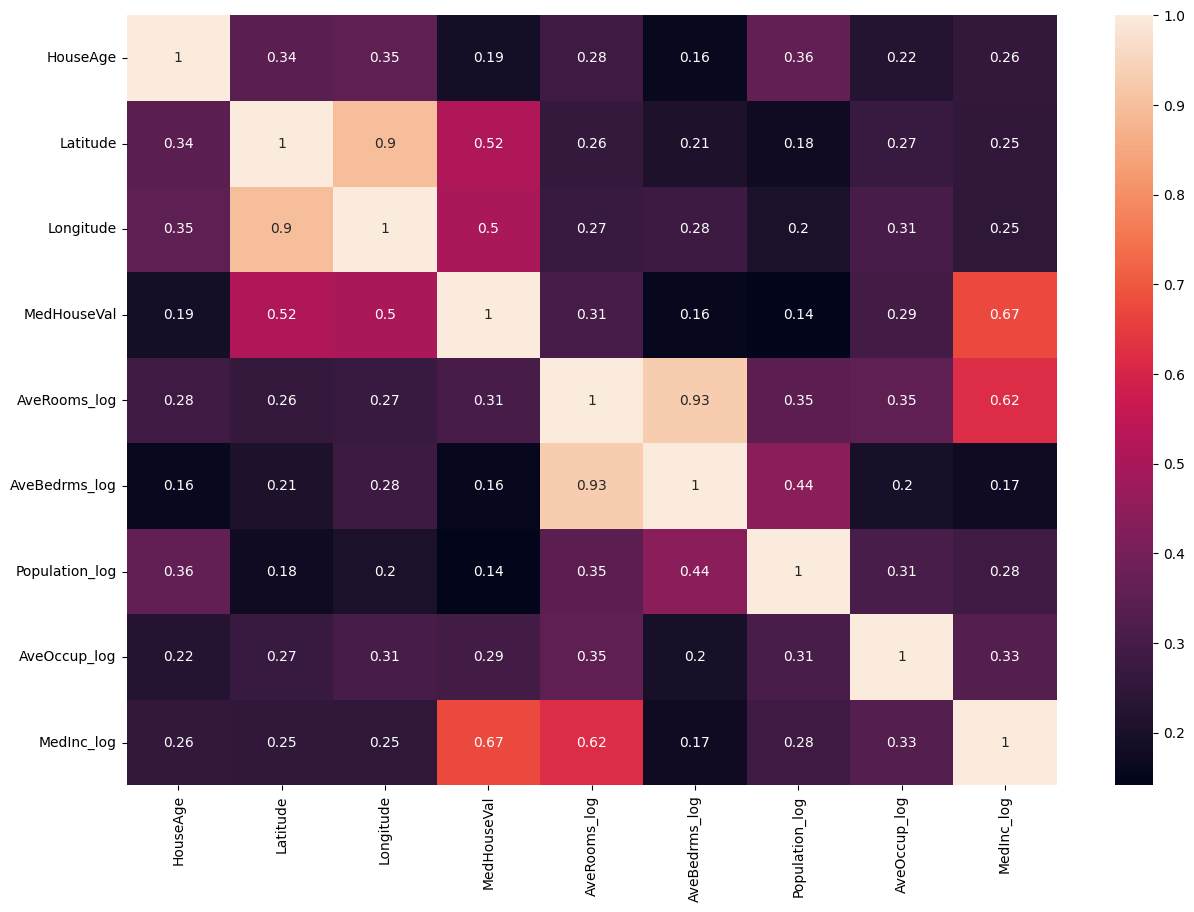

In [354]:
phik_matrix = df.phik_matrix()

plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(phik_matrix, 
            xticklabels=phik_matrix.columns.values,
            yticklabels=phik_matrix.columns.values,
            annot=True)
plt.show()

# ML

In [355]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [356]:
TARGET_COL_NAME = 'MedHouseVal'
N_SPLITS = 5

In [357]:
y = df[TARGET_COL_NAME]
X = df.drop(columns=TARGET_COL_NAME)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [358]:
def regression_kfolds_cross_validation(
    X, 
    y, 
    model_class,
    model_params,
    n_splits=5, 
    metrics_dict=None
):
    """
    Кросс-валидация для регрессии с предобработкой данных.

    Parameters:
        X (pd.DataFrame): Фичи.
        y (pd.Series): Целевая переменная (непрерывная).
        model_class (class): Класс регрессора (например, LinearRegression).
        model_params (dict): Гиперпараметры модели.
        n_splits (int): Количество фолдов.
        metrics_dict (dict): Словарь метрик вида {name: function}.

    Returns:
        pipelines (list): Обученные пайплайны для каждого фолда.
        predictions (list): Предсказания для каждого фолда.
        scores (dict): Результаты метрик.
    """
    if metrics_dict is None:
        metrics_dict = {
            'mse': mean_squared_error,
            'mae': mean_absolute_error,
            'r2': r2_score
        }

    kf = KFold(n_splits=n_splits)
    scores = {key: [] for key in metrics_dict}
    pipelines = []
    val_indexes = []
    predictions = []
    true_answers = []

    # Создаем трансформер
    preprocessor = make_column_transformer(
        (StandardScaler(), make_column_selector(dtype_include=np.number)),
        (OneHotEncoder(), make_column_selector(dtype_include=object))
    )

    for train_index, val_index in kf.split(X, y):
        # Разделение данных
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        val_indexes.append(X.iloc[val_index].index.values.tolist())
        true_answers.append(y_val)

        # Создаем пайплайн
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model_class(**model_params))
        ])

        # Обучение
        pipe.fit(X_train, y_train)

        # Предсказание
        y_pred = pipe.predict(X_val)
        predictions.append(y_pred)

        # Вычисление метрик
        for name, metric in metrics_dict.items():
            score = metric(y_val, y_pred)
            scores[name].append(score)

        pipelines.append(pipe)

    return pipelines, val_indexes, predictions, true_answers, scores

In [359]:
pipes, res_val_indexes, res_preds, res_true_answers, res_scores = regression_kfolds_cross_validation(
    X_train, 
    y_train, 
    model_class=RandomForestRegressor,
    model_params={'n_estimators': 100},
    n_splits=N_SPLITS,
    metrics_dict={'mse': mean_squared_error, 'mae': mean_absolute_error, 'r2': r2_score}
)

for name, score in res_scores.items():
    print(f'{name}: {np.mean(score)}')

mse: 0.21130788021730754
mae: 0.31145684154645337
r2: 0.7720657353340116


In [360]:
def make_prediction(X, y, pipes):
    y_pred = 0
    for pipe in pipes:
        y_pred += pipe.predict(X)
    y_pred /= len(pipes)
    for i, true in enumerate(list(y)):
        print(f'Номер объекта: {X.index.values.tolist()[i]}, Предсказанное значение: {y_pred[i]:.3f}, Истинное значение: {true}')

# 1:10
# 250:260
# 550:565

X = X_test[250:260]
y = y_test[250:260]
make_prediction(X, y, pipes)

Номер объекта: 10135, Предсказанное значение: 2.433, Истинное значение: 2.671
Номер объекта: 12012, Предсказанное значение: 2.599, Истинное значение: 2.464
Номер объекта: 7707, Предсказанное значение: 2.866, Истинное значение: 3.266
Номер объекта: 16723, Предсказанное значение: 1.879, Истинное значение: 1.761
Номер объекта: 9057, Предсказанное значение: 1.394, Истинное значение: 1.011
Номер объекта: 2627, Предсказанное значение: 0.970, Истинное значение: 1.005
Номер объекта: 16227, Предсказанное значение: 1.178, Истинное значение: 0.888
Номер объекта: 17458, Предсказанное значение: 2.314, Истинное значение: 2.25
Номер объекта: 13975, Предсказанное значение: 0.959, Истинное значение: 0.89
Номер объекта: 15472, Предсказанное значение: 1.656, Истинное значение: 1.392


In [361]:
def get_test_predictions(X_test, pipes):
    """
    Получение усредненных предсказаний для тестовых данных
    
    Parameters:
        X_test (pd.DataFrame): Тестовые данные
        pipes (list): Список обученных пайплайнов
        
    Returns:
        y_pred (np.array): Усредненные предсказания
    """
    y_pred = np.zeros(X_test.shape[0])
    for pipe in pipes:
        y_pred += pipe.predict(X_test)
    return y_pred / len(pipes)

def evaluate_test_metrics(X_test, y_test, pipes):
    """
    Вычисление метрик на тестовых данных
    
    Parameters:
        X_test (pd.DataFrame): Тестовые данные
        y_test (pd.Series): Истинные значения
        pipes (list): Список обученных пайплайнов
        
    Returns:
        dict: Словарь с метриками качества
    """
    y_pred = get_test_predictions(X_test, pipes)
    
    return {
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
    }

def print_predictions(X, y, pipes):
    """
    Печать предсказаний для всех объектов
    
    Parameters:
        X (pd.DataFrame): Данные
        y (pd.Series): Истинные значения
        pipes (list): Список обученных пайплайнов
    """
    y_pred = get_test_predictions(X, pipes)
    for idx, pred, true in zip(X.index, y_pred, y):
        print(f'Номер объекта: {idx}, Предсказанное значение: {pred:.3f}, Истинное значение: {true:.3f}')


In [362]:
metrics = evaluate_test_metrics(X_test, y_test, pipes)
print("Test metrics:")
for metric, value in metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

Test metrics:
R2: 0.7738
MSE: 0.2094
MAE: 0.3101
RMSE: 0.4576


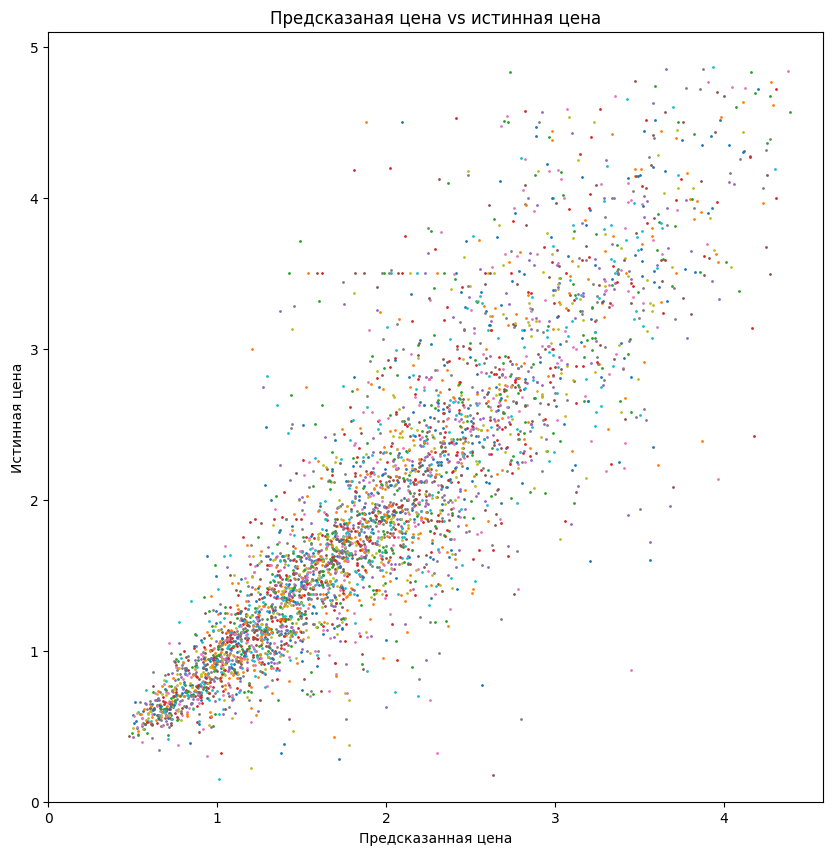

In [363]:
fig = plt.figure(figsize=(10, 10))
y_pred = get_test_predictions(X_test, pipes)
for pred, true in zip(y_pred, y_test):
    plt.scatter(pred, true, s=1)
plt.title("Предсказаная цена vs истинная цена")
plt.xlabel('Предсказанная цена')
plt.ylabel('Истинная цена')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.show()

In [364]:
def regression_kfolds_with_hyperopt(
    X, 
    y, 
    model_class=RandomForestRegressor,  # По умолчанию RF
    param_grid=None,                    # Сетка параметров для поиска
    n_splits=5,
    metrics_dict=None
):
    """
    Кросс-валидация с подбором гиперпараметров.
    
    Parameters:
        X (pd.DataFrame): Фичи.
        y (pd.Series): Целевая переменная.
        model_class: Класс модели (например, RandomForestRegressor).
        param_grid (dict): Сетка параметров для GridSearch.
        n_splits (int): Число фолдов.
        metrics_dict (dict): Метрики для оценки.
        
    Returns:
        best_models (list): Лучшие модели для каждого фолда.
        best_params (list): Лучшие параметры для каждого фолда.
        all_scores (dict): Метрики на валидационных фолдах.
    """
    if param_grid is None:
        param_grid = {
            'model__max_depth': [3, 5, 7, None],    # Глубина дерева
            'model__n_estimators': [50, 100]        # Число деревьев
        }
    
    if metrics_dict is None:
        metrics_dict = {
            'mse': mean_squared_error,
            'mae': mean_absolute_error,
            'r2': r2_score
        }

    kf = KFold(n_splits=n_splits)
    best_models = []
    best_params = []
    answers = []
    true_answers = []
    all_scores = {k: [] for k in metrics_dict.keys()}

    # Препроцессинг
    preprocessor = make_column_transformer(
        (RobustScaler(), make_column_selector(dtype_include=np.number)),
        (OneHotEncoder(), make_column_selector(dtype_include=object))
    )

    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Пайплайн с GridSearch внутри фолда
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model_class())
        ])
        
        # Поиск по сетке ТОЛЬКО на тренировочных данных фолда
        grid_search = GridSearchCV(
            pipe,
            param_grid,
            cv=5,  # Количество слоев кросс-валидации для подбора
            scoring='neg_mean_squared_error',
            n_jobs=8
        )
        grid_search.fit(X_train, y_train)

        # Лучшая модель
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)
        
        # Сохраняем результаты
        answers.append(y_pred)
        true_answers.append(y_val)
        best_models.append(best_model)
        best_params.append(grid_search.best_params_)
        
        for name, metric in metrics_dict.items():
            all_scores[name].append(metric(y_val, y_pred))

    return best_models, best_params, all_scores, answers, true_answers

In [365]:
param_grid = {
    'model__max_depth': [3, 5, 7, None],  # None - без ограничения глубины
    'model__min_samples_split': [2, 5],
    'model__n_estimators': [50, 100, 250]
}

best_models, best_params, scores, answers, true_answers = regression_kfolds_with_hyperopt( X_train, 
                                                                    y_train,
                                                                    model_class=RandomForestRegressor,
                                                                    param_grid=param_grid,
                                                                    n_splits=3)

# Результаты
print("Лучшие параметры в каждом фолде:")
for i, params in enumerate(best_params):
    print(f"Фолд {i+1}: {params}")


for name, score in scores.items():
    print(f'{name}: {np.mean(score)}')

Лучшие параметры в каждом фолде:
Фолд 1: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 250}
Фолд 2: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 250}
Фолд 3: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 250}
mse: 0.21665031558822792
mae: 0.3160309486992045
r2: 0.7662093983048681


In [366]:
metrics = evaluate_test_metrics(X_test, y_test, best_models)
print("Test metrics:")
for metric, value in metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

Test metrics:
R2: 0.7713
MSE: 0.2117
MAE: 0.3137
RMSE: 0.4601


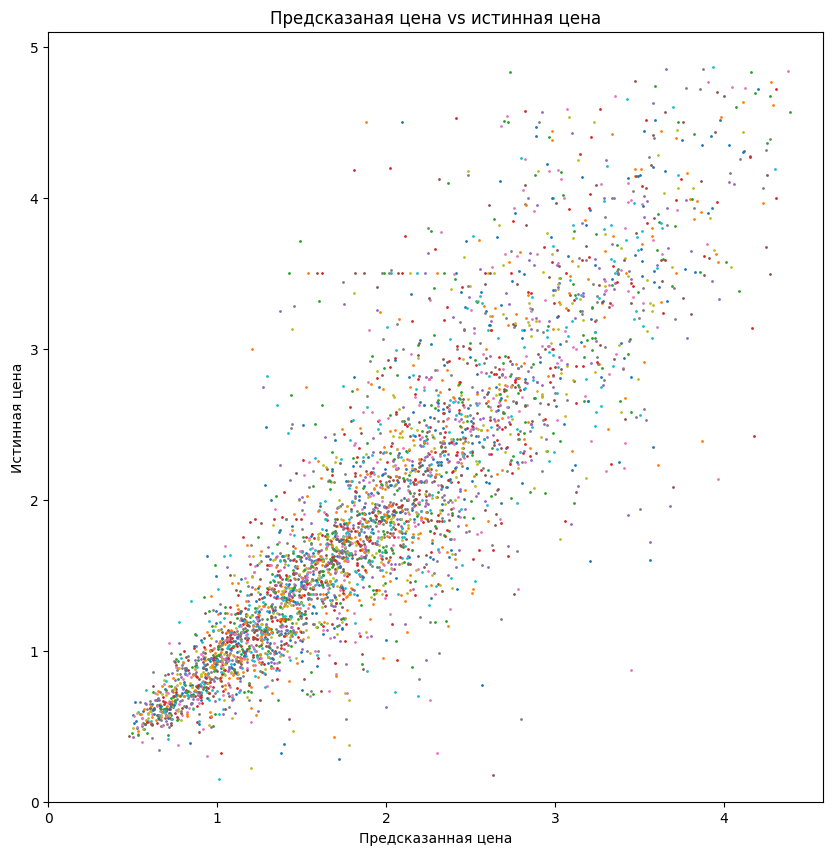

In [367]:
fig = plt.figure(figsize=(10, 10))
y_pred = get_test_predictions(X_test, pipes)
for pred, true in zip(y_pred, y_test):
    plt.scatter(pred, true, s=1)
plt.title("Предсказаная цена vs истинная цена")
plt.xlabel('Предсказанная цена')
plt.ylabel('Истинная цена')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.show()